### File for generating figures for DNN filter paper

In [2]:
#setup - rememeber to switch to tensorflow 2.3 kernel...
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import scipy.io as sio
import datetime
import trimesh
import time
from vedo import *
from ipyvtklink.viewer import ViewInteractiveWidget

#limit GPU memory ------------------------------------------------
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
if gpus:
  try:
    tf.config.experimental.set_virtual_device_configuration(gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=2048)])
  except RuntimeError as e:
    print(e)
#-----------------------------------------------------------------

print(tf.__version__)

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'
%matplotlib notebook

%load_ext tensorboard

# for auto-reloading external modules
%load_ext autoreload
%autoreload 2
%autosave 180

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
2.10.0


2022-10-03 10:36:03.096261: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-03 10:36:03.121751: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-03 10:36:03.121962: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


Autosaving every 180 seconds


In [3]:
#load mesh of object
surf_fn = "C:/Users/Derm/vaRLnt/v3/perspective_shift/figures/wall_scaled.stl"
M = trimesh.load(surf_fn)
#get ground truth translation
gt = np.loadtxt("C:/Users/Derm/vaRLnt/v3/perspective_shift/figures/gt.txt")
print(gt)
#load point clouds of surface generated in Matlab
pts1_fn = "C:/Users/Derm/vaRLnt/v3/perspective_shift/figures/s1.txt"
pts1 = np.loadtxt(pts1_fn)
pts2_fn = "C:/Users/Derm/vaRLnt/v3/perspective_shift/figures/s2.txt"
pts2 = np.loadtxt(pts2_fn)
# pts = pts - gt #+ np.array([20,5,1.72])

#temp for making wall fig
pts2 = pts2[pts2[:,1] < -39]
pts1 = pts1[pts1[:,1] < -40]
print(np.shape(pts2))

ValueError: string is not a file: C:/Users/Derm/vaRLnt/v3/perspective_shift/figures/wall_scaled.stl

In [43]:
#plot with Vedo
plt1 = Plotter(N = 1, axes = 4, bg = (1, 1, 1), interactive = True)
disp = []
disp.append(Points(pts1, c = 'red', r = 5, alpha = 1))
disp.append(Points(pts2 - np.array([1,1,0]), c = 'blue', r = 5, alpha = 1))
w1 = Mesh(M).c("gray").alpha(1)
w1.pos(gt[0], gt[1], gt[2])
print(gt[2])
# disp.append(w1)

# L = Light(pos = (30,30,30), focalPoint = (0,0,0), angle = 180, c = (1,1,1), intensity = 1, removeOthers = False)
# disp.append(L)

plt1.show(disp, "Fig 2.1")
ViewInteractiveWidget(plt1.window)

-5.2


ViewInteractiveWidget(height=960, layout=Layout(height='auto', width='100%'), width=960)

## Plot Points + distributions

In [4]:
#Run ICET
import os
import sys
import inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(os.path.dirname(currentdir))
sys.path.insert(0, parentdir)

print(currentdir)
print(parentdir)

from ICET_spherical import ICET

D = True
# D = False
it1 = ICET(cloud1 = pts1, cloud2 = pts2,  fid = 70, draw = D, 
            niter = 5, group= 2, RM = False, DNN_filter = False)

#add mesh to ICET visualization
w2 = Mesh(M).c("gray").alpha(0.25)
w2.pos(gt[0], gt[1], gt[2])
it1.disp.append(w2)
it1.plt.show(it1.disp, "Figure 2", resetcam = False)

ViewInteractiveWidget(it1.plt.window)

C:\Users\Derm\vaRLnt\v3\perspective_shift\figures
C:\Users\Derm\vaRLnt\v3

 estimated solution vector X: 
 tf.Tensor([0. 0. 0. 0. 0. 0.], shape=(6,), dtype=float32)

 estimated solution vector X: 
 tf.Tensor(
[ 1.7162377e-04  5.4697541e-04  8.2900602e-05 -9.3621127e-03
 -1.3084501e-02 -2.2128481e-02], shape=(6,), dtype=float32)

 estimated solution vector X: 
 tf.Tensor([ 0.09726354  0.08303583  0.01057386  0.00068033 -0.00225577 -0.02273422], shape=(6,), dtype=float32)

 estimated solution vector X: 
 tf.Tensor([ 0.09840114  0.08403488  0.01082271  0.00388827  0.00193967 -0.02257173], shape=(6,), dtype=float32)

 estimated solution vector X: 
 tf.Tensor([ 0.09818026  0.08384597  0.01079576  0.00366667  0.00192116 -0.02257625], shape=(6,), dtype=float32)
pred_stds: 
 tf.Tensor([0.00111894 0.00095357 0.00014558 0.00128036 0.00122486 0.00011519], shape=(6,), dtype=float32)
 L2: 
 tf.Tensor(
[[1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 

ViewInteractiveWidget(height=960, layout=Layout(height='auto', width='100%'), width=960)

## Missed Detection/ False Alarm plots

In [4]:
import matplotlib.pyplot as plt
import scipy as sp
from scipy import stats
import numpy as np

plt.rcParams.update({
    "font.family": "serif",
    "font.sans-serif": ["Times"],
    "font.size": 12})

<IPython.core.display.Javascript object>


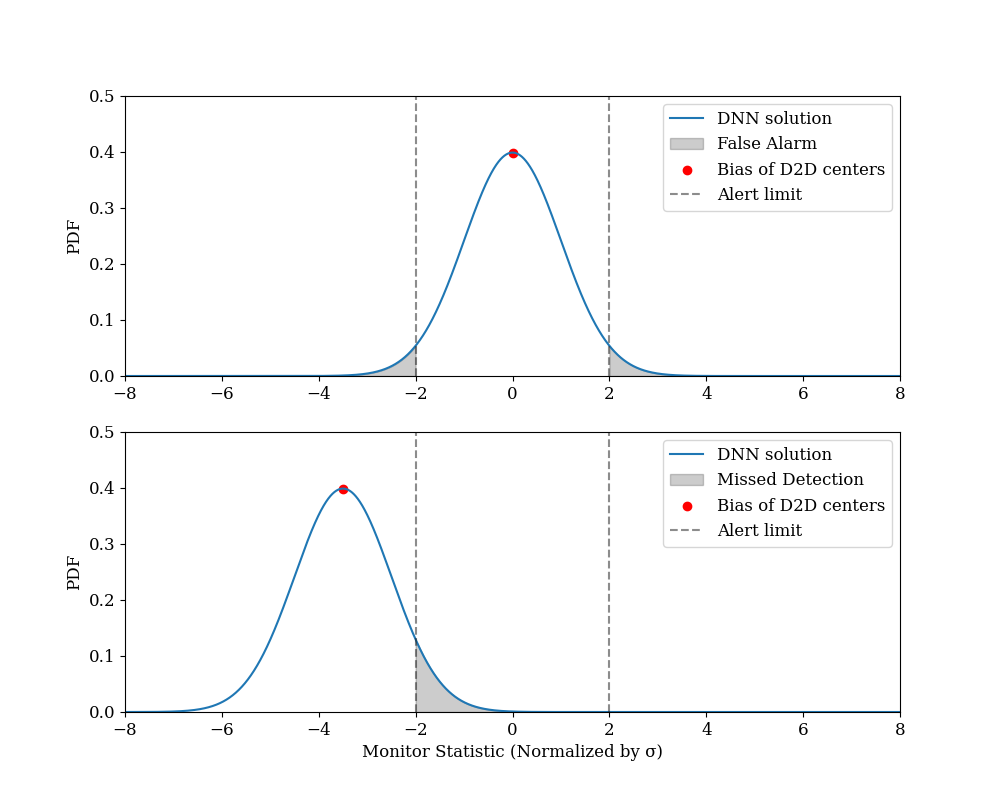

0.3989422804014327


In [5]:
fig, ax = plt.subplots(2,1)

thresh = 2
width = 8
xlim = 8
bias = -3.5

#Top Plot: 
x_data = np.arange(-width, width, 0.001)
y_data = stats.norm.pdf(x_data, 0, 1)
ax[0].plot(x_data, y_data, label = "DNN solution")
ax[0].set_ylim(0,0.5)
ax[0].set_xlim(-xlim,xlim)
ax[0].set_ylabel("PDF")
ax[0].fill_between(x_data[x_data > thresh],
                   stats.norm.pdf(x_data[x_data > thresh], 0, 1), 
                   color = [0,0,0], alpha = 0.2, label = 'False Alarm')
ax[0].fill_between(x_data[x_data < -thresh],
                   stats.norm.pdf(x_data[x_data < -thresh], 0, 1), 
                   color = [0,0,0], alpha = 0.2)
ax[0].scatter(0, np.max(y_data), color = (1,0,0), label = 'Bias of D2D centers')
ax[0].plot(thresh*np.ones([10,1]), np.linspace(0, 0.5, 10), ls = '--', color = (0.1, 0.1, 0.1, 0.5), label = "Alert limit")
ax[0].plot(-thresh*np.ones([10,1]), np.linspace(0, 0.5, 10), ls = '--', color = (0.1, 0.1, 0.1, 0.5))
ax[0].legend(loc = 'upper right')

#Bottom Plot
ax[1].set_xlabel("Monitor Statistic (Normalized by σ)")
ax[1].set_ylabel("PDF")
x_data = np.arange(-width, width, 0.001)
y_data = stats.norm.pdf(x_data-bias, 0, 1)
ax[1].plot(x_data, y_data, label = "DNN solution")
ax[1].set_ylim(0,0.5)
ax[1].set_xlim(-xlim,xlim)
ax[1].set_ylabel("PDF")
if bias > 0:
    ax[1].fill_between(x_data[x_data < thresh],
                       stats.norm.pdf(x_data[x_data < thresh] - bias, 0, 1), 
                       color = [0,0,0], alpha = 0.2, label = 'False Alarm')
if bias < 0:
    ax[1].fill_between(x_data[x_data > -thresh],
                       stats.norm.pdf(x_data[x_data > -thresh] - bias, 0, 1), 
                       color = [0,0,0], alpha = 0.2, label = 'Missed Detection')
ax[1].scatter(bias, np.max(y_data), color = (1,0,0), label = 'Bias of D2D centers')
ax[1].plot(thresh*np.ones([10,1]), np.linspace(0, 0.5, 10), ls = '--', color = (0.1, 0.1, 0.1, 0.5), label = "Alert limit")
ax[1].plot(-thresh*np.ones([10,1]), np.linspace(0, 0.5, 10), ls = '--', color = (0.1, 0.1, 0.1, 0.5))
ax[1].legend(loc = 'upper right')

print(np.max(y_data))

## Figure 1: draw multiple objects in same scene

In [6]:
# bgc = (0,0,0)
bgc = (1,1,1) #background color
mc  = (0.5,0.5,0.5) #'white' #
plt2 = Plotter(N = 1, axes = 4, bg = bgc, interactive = True)
disp2 = []
alph = 0.8#alpha for points
rad = 2

#load point clouds
c1 = np.loadtxt('fig1_s1.txt') 
c2 = np.loadtxt('fig1_s2.txt')
gt = np.loadtxt('fig1_gt.txt')
print(gt)
ground = -2.55 #define ground height
c1_ground = c1[c1[:,2] < ground]
c2_ground = c2[c2[:,2] < ground]
c1 = c1[c1[:,2] > ground] #remove ground plane
c2 = c2[c2[:,2] > ground]

surf_fn = "Assembly1_scaled.stl"
M = trimesh.load(surf_fn)
w1 = Mesh(M).c(mc).alpha(1)
w1.pos(0, 0, -1.2)
w1.crop(bounds = [-10,10,-10,10,-1.45,5])
disp2.append(w1)

vox_fn = "voxel.stl"
v1 = Mesh(trimesh.load(vox_fn)).c((0,0,0)) #draw voxel around head of dummy
v1.pos(-5.5,7.5,0)
disp2.append(v1)

v2 = Mesh(trimesh.load(vox_fn)).c((0,0,0))
v2.pos(2.5,7,-1)
disp2.append(v2)


#add light 
L = Light(pos = (0,-10,30), focalPoint = (0,0,0), angle = 180, c = (1,1,1), intensity = 1, removeOthers = False)
# disp2.append(L)

disp2.append(Points(c1, c = 'red', r = rad, alpha = alph))
disp2.append(Points(c2 - gt/10, c = 'blue', r = rad, alpha = alph))
disp2.append(Points(c1_ground, c = 'red', r = rad, alpha = alph/4))
disp2.append(Points(c2_ground - gt/10, c = 'blue', r = rad, alpha = alph/4))

plt2.show(disp2, "Figure 1")
ViewInteractiveWidget(plt2.window)

[100.   0.   0.]


ViewInteractiveWidget(height=1376, layout=Layout(height='auto', width='100%'), width=2488)